<div style="background-color: #387390; color: white; text-align: center;">
    <h1>Multiclass Prediction on Obesity Rates</h1>
</div>

The dataset for this competition, both train and test sets, was generated from a deep learning model trained on the Obesity or Cardiovascular Disease (CVD) risk dataset. While the feature distributions closely resemble the original dataset, they are not exactly the same. As part of this competition, participants are encouraged to explore the differences between the generated dataset and the original dataset, and to investigate whether incorporating the original dataset in training improves model performance.

This notebook presents a solution for the multi-class prediction of obesity risk using Python. It utilizes various machine learning models including Neural Networks, Random Forest Classifier, XGBoost (XGB), and LightGBM (LGBM).

**Table of Contents**
1. [Import Libraries](#import-libraries)
2. [List of Features](#list-of-features)
    - 2.1 [Short Exploration and Data Prep](#short-eda)
3. [Feature Engineering](#feature-engineering)
    - 3.1 [Approach One: One-Hot-Encoding](#approach-1)
    - 3.2 [Approach Two: Feature Engineering](#approach-2)
4. [Modeling](#modeling)
    - 4.1 [Neural Network Modeling](#nn_model)
    - 4.2 [Random Forest](#rf_model)
    - 4.3 [Grid Search](#grid_search)
    - 4.4 [Random Forest Feature Selection](#rf_features)





5. [Appendix](#appendix)



<div id="import-libraries" style="background-color: #387390; color: white; text-align: center;">
    <h2>1. Import Libraries</h2>
</div>


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
import os

import pytorch_lightning as pl
import torch
from torch import nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchmetrics.functional import accuracy
import mlflow
import mlflow.pytorch

from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset

from pytorch_lightning.loggers import MLFlowLogger

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import mlflow.pyfunc


<div id="load-explore" style="background-color: #387390; color: white; text-align: center;">
    <h1>2. Load and Explore Data</h2>
</div>


In [6]:
# Define the path to the data directory
data_dir = 'data/'

# Construct the file paths for train and test data
train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')

# Read train and test data
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

train.head()


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**List of features:**

- **Gender**: Represents the gender of the individual.
- **Age**: Indicates the age of the individual.
- **Height**: Specifies the height of the individual.
- **Weight**: Represents the weight of the individual.
- **Family History with Overweight**: Indicates familiarity with obesity within the family.
- **FAVC**: Denotes the frequent consumption of high-caloric food.
- **FCVC**: Represents the frequency of consumption of vegetables.
- **NCP**: Indicates the number of main meals consumed.
- **CAEC**: Represents the consumption of food between meals.
- **SMOKE**: Indicates tobacco usage.
- **CH20**: Denotes the consumption of water daily.
- **SCC**: Specifies calories consumption monitoring.
- **FAF**: Represents physical activity frequency.
- **TUE**: Denotes time using technology devices.
- **CALC**: Indicates consumption of alcohol.
- **MTRANS**: Specifies the transportation used.


<div id='short-eda' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; background-color: transparent;">2.1.</h2><h2 style="display:inline;"> Short Exploration and Data Prep</h2>
</div>


In [7]:
#Explore the size of the provided data
# Train Data
print("Train Data")
print(f"Total number of rows: {train.shape[0]}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
print("Test Data")
print(f"Total number of rows: {test.shape[0]}")
print(f"Total number of columns: {test.shape[1]}")

Train Data
Total number of rows: 20758
Total number of columns: 18

Test Data
Total number of rows: 13840
Total number of columns: 17


In [8]:
# Check for missing values in train dataset
print("Missing Values in Train Data:")
print(train.isna().any().any())

# Check for missing values in test dataset
print("Missing Values in Test Data:")
print(test.isna().any().any())

Missing Values in Train Data:
False
Missing Values in Test Data:
False


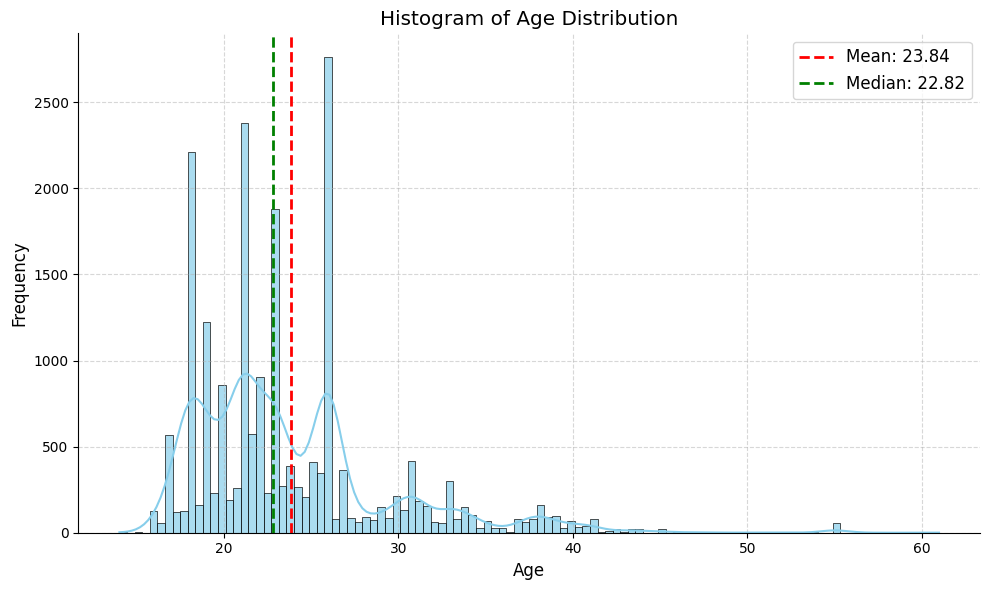

In [9]:
# Assuming 'train' is your DataFrame and 'Age' is one of its columns
data = train['Age']

# Calculate basic statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)

# Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color='skyblue', alpha=0.7)

# Add a vertical line for the mean
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Add legend and labels
plt.legend(fontsize='large')
plt.title('Histogram of Age Distribution', fontsize='x-large')
plt.xlabel('Age', fontsize='large')
plt.ylabel('Frequency', fontsize='large')

# Set grid
plt.grid(True, linestyle='--', alpha=0.5)

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


The graph shows that the age distribution is skewed young, with a large number of people in their 20s and early 30s. The number of people then gradually declines as age increases. The mean age is 23.84 years old, and the median age is 22.82 years old.

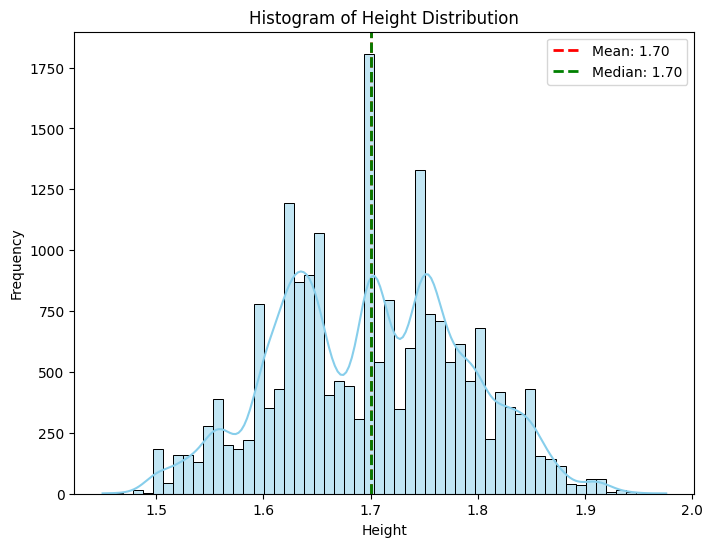

In [10]:
#checking height
data = train.Height
# Calculate basic statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
sns.histplot(data, kde=True, color='skyblue')

# Add a vertical line for the mean
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Add legend and labels
plt.legend()
plt.title('Histogram of Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Show plot
plt.show()


The graph shows that the most common respondents' heights are between 1.6 and 1.8. There are fewer people that are shorter or taller than this range. The mean height of a person is 1.7, and the median height is also 1.7.

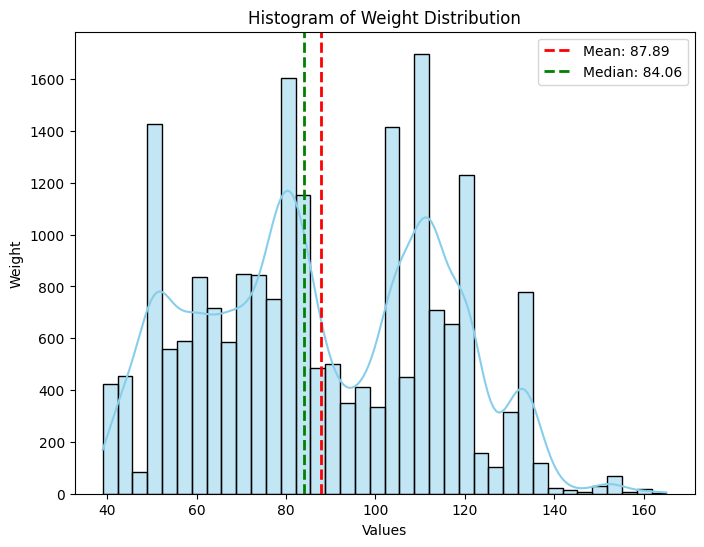

In [11]:
#checking height
data = train.Weight
# Calculate basic statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
sns.histplot(data, kde=True, color='skyblue')

# Add a vertical line for the mean
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Add legend and labels
plt.legend()
plt.title('Histogram of Weight Distribution')
plt.xlabel('Values')
plt.ylabel('Weight')

# Show plot
plt.show()


The distribution is skewed to the right, meaning there are more people on the lower end of the weight range than the higher end. The mean weight is 87.89 kg and the median weight is 84.06 kg. This means that the average person is slightly heavier than the middle person. The most frequent weight range is between 60 and 80 kg, with over 1400 people falling within this range. There are fewer than 200 people in the heaviest weight range (140-160 kg).


<div id='feature-engineering' style="background-color: #387390; color: white; text-align: center;">
    <h1>3. Feature Engineering</h2>
</div>


We will employ multiple approaches for feature engineering. Our first approach involves transforming several columns into one-hot encoded variables. By employing one-hot encoding, we ensure that categorical data is properly represented in a numerical format, enabling models to effectively learn patterns and relationships within the data. For our second approach, inspired by Luca Massaron (link: [here](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/473220)), we introduce new distinct features such as BMI, Physical Activity Level,Meal Habits, and Tech Usage Score. The accuracy of all modeling approaches will be documented in a table presented in the appendix. You can find the table in the appendix section by following this [link](#appendix). For first modeling approaches, we use all features.

<div id='approach-1' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">3.1.</h2><h2 style="display:inline;"> Approach One: One-Hot-Encoding</h2>
</div>


We are changing 'no', 'yes' and other objects to take numeric values in order to further one-hot encode them.

In [12]:
# Replacing 'yes' and 'no' with 1 and 0 respectively
df = train
df.replace({'SMOKE': {'no': 0, 'yes': 1}, 
             'family_history_with_overweight': {'no': 0, 'yes': 1},
             'SCC': {'no': 0, 'yes': 1},
             'FAVC': {'no': 0, 'yes': 1},}, inplace=True)

# Replacing other values in the specified columns
df.replace({'CAEC': {'no': 0, 'Sometimes': 2, 'Always': 1, 'Frequently': 1}, 
             'CALC': {'Sometimes': 1, 'no': 0, 'Frequently': 2}}, inplace=True)


In [13]:
df = pd.get_dummies(df, columns = ['Gender', 'CAEC', 'SMOKE', 'MTRANS'],  dtype=float)
df.head()

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,SCC,...,CAEC_0,CAEC_1,CAEC_2,SMOKE_0,SMOKE_1,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2.763573,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2.000000,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1.910378,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1.674061,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1.979848,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's write function that will manage all modifications needed for the future test.csv.


In [14]:
def prepare_data(test):
    # Filtering out rows where Age is less than 50
    df = test
    # Replacing 'yes' and 'no' with 1 and 0 respectively
    df.replace({'SMOKE': {'no': 0, 'yes': 1}, 
                'family_history_with_overweight': {'no': 0, 'yes': 1},
                'SCC': {'no': 0, 'yes': 1},
                'FAVC': {'no': 0, 'yes': 1}}, inplace=True)
 
    # Replacing other values in the specified columns
    df.replace({'CAEC': {'no': 0, 'Sometimes': 2, 'Always': 1, 'Frequently': 1}, 
                'CALC': {'Sometimes': 1, 'no': 0, 'Frequently': 2, 'Always' : 1}}, inplace=True)

    # One-hot encoding for specified columns
    df = pd.get_dummies(df, columns=['Gender', 'CAEC', 'SMOKE', 'MTRANS'], dtype=float)

    return df


<div id='approach-2' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">3.2.</h2><h2 style="display:inline;"> Approach Two: Feature Engineering</h2>
</div>


* BMI is widely recognised metric, that can be calculated as BMI = $\frac{weight_{kg}}{height_{m}^2}$
* Physical Activity Level is calculated by substraction TUE form FAF
* Meal Habits is a combination of 'FCVC' (Frequency of consumption of vegetables) and 'NCP' (Number of main meals). Made to check overall dietary patterns.
* Tech Usage Score weights the frequency of technology usage by the individual's age. 




In [15]:
def calculate_additional_features(df):
    # Calculate BMI
    df['BMI'] = df['Weight'] / df['Height'] ** 2
    
    # Calculate Physical Activity Level
    df['Physical_Activity_Level'] = df['TUE'] - df['FAF']
    
    # Calculate Meal Habits
    df['Meal_Habits'] = df['FCVC'] * df['NCP']
    
    # Calculate Tech Usage Score
    df['Tech_Usage_Score'] = df['TUE'] / df['Age']
    
    return df

df = df.assign(
    BMI=lambda x: x['Weight'] / x['Height'] ** 2,
    Physical_Activity_Level=lambda x: x['TUE'] - x['FAF'],
    Meal_Habits=lambda x: x['FCVC'] * x['NCP'],
    Tech_Usage_Score=lambda x: x['TUE'] / x['Age']
)

df.head()


,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,SCC,...,SMOKE_1,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,BMI,Physical_Activity_Level,Meal_Habits,Tech_Usage_Score
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2.763573,0,...,0.0,0.0,0.0,0.0,1.0,0.0,28.259565,0.976473,5.966594,0.039949
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2.000000,0,...,0.0,1.0,0.0,0.0,0.0,0.0,23.422091,0.000000,6.000000,0.055556
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1.910378,0,...,0.0,0.0,0.0,0.0,1.0,0.0,17.126706,0.807539,2.654722,0.092977
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1.674061,0,...,0.0,0.0,0.0,0.0,1.0,0.0,44.855798,-0.687664,9.000000,0.037236
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1.979848,0,...,0.0,0.0,0.0,0.0,1.0,0.0,25.599151,-1.036252,5.282883,0.029447


In [16]:
df = df.set_index('id')

<div id='modeling' style="background-color: #387390; color: white; text-align: center;">
    <h1 style="display:inline; color: white;">4.0.</h2><h2 style="display:inline;"> Modeling</h2>
</div>




<div id='nn_model' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">4.1.</h2><h2 style="display:inline;">Neural Networks Modeling</h2>
</div>





In [17]:
class ObesityModel(pl.LightningModule):
    def __init__(self, input_dim, num_classes):
        super(ObesityModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.l1 = nn.Linear(input_dim, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, num_classes)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        logits = self.l3(h2)
        return logits

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        l = self(x)
        J = self.loss(l, y)
        acc = accuracy(l, y, num_classes=self.num_classes, task="multiclass")
        self.log('train_loss', J, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        mlflow.log_metric('train_loss', J.item())  # Log training loss
        mlflow.log_metric('train_acc', acc.item())  # Log training accuracy
        return {'loss': J}

    def test_step(self, batch, batch_idx):
        x, y = batch
        l = self(x)
        J = self.loss(l, y)
        acc = accuracy(l, y, num_classes=self.num_classes)
        self.log('test_loss', J, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        mlflow.log_metric('test_loss', J.item())  # Log test loss
        mlflow.log_metric('test_acc', acc.item())  # Log test accuracy
        return {'test_loss': J, 'test_acc': acc}

    def prepare_data(self):
        # Load and preprocess the dataset
        data = df
        x = data.drop(columns=["NObeyesdad"])
        y = data['NObeyesdad']
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        self.x_train = torch.tensor(x_train.values, dtype=torch.float32)
        self.x_test = torch.tensor(x_test.values, dtype=torch.float32)
        self.y_train = torch.tensor(y_train, dtype=torch.long)
        self.y_test = torch.tensor(y_test, dtype=torch.long)

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.x_train, self.y_train), batch_size=64, shuffle=True)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.x_test, self.y_test), batch_size=64)

    def on_train_start(self):
        #mlflow.set_experiment('obesity_model')
        mlflow.set_tag('obesity_nn_1', 'ObesityModel')

    def on_train_end(self):
        mlflow.pytorch.log_model(self, "model")

    def teardown(self, stage=None):
        mlflow.end_run()

In [18]:
# Instantiate the model
model = ObesityModel(input_dim=28, num_classes=7)


# Define the Lightning Trainer
trainer = pl.Trainer(max_epochs=10)

# Run the training
with mlflow.start_run():
    trainer.fit(model)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name | Type             | Params
------------------------------------------
0 | l1   | Linear           | 3.7 K 
1 | l2   | Linear           | 8.3 K 
2 | l3   | Linear           | 455   
3 | loss | CrossEntropyLoss | 0     
------------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [19]:
# saving metrics for further aggregating them into table

runs = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name('Default').experiment_id)

# Display the metrics for the first run (change index as needed)
run_id = runs.iloc[0]["run_id"]
metrics = mlflow.get_run(run_id).data.metrics

In [20]:
metrics

{'train_acc': 0.6000000238418579, 'train_loss': 0.8401350378990173}

In [21]:
# Define the model name and metrics dictionary
model_name = "First Neural Network"

# Round train accuracy to two decimals
train_acc_rounded = round(metrics['train_acc'], 2)

# Create DataFrame from dictionary
metrics_table = pd.DataFrame({'Model Name': ['First Neural Network'],
                   'Train Accuracy': [train_acc_rounded]})

# Display the DataFrame
metrics_table

,Model Name,Train Accuracy
0,First Neural Network,0.6


Accuracy is low. Let's try to improve architecture.



In [22]:
class ImprovedObesityModel(pl.LightningModule):
    def __init__(self, input_dim, num_classes):
        super(ImprovedObesityModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.l1 = nn.Linear(input_dim, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, num_classes)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization layer
        self.bn2 = nn.BatchNorm1d(64)   # Batch normalization layer
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.loss = nn.CrossEntropyLoss()
        #mlflow.start_run()

    def forward(self, x):
        h1 = nn.functional.relu(self.bn1(self.l1(x)))
        h1 = self.dropout(h1)  # Apply dropout
        h2 = nn.functional.relu(self.bn2(self.l2(h1)))
        h2 = self.dropout(h2)  # Apply dropout
        logits = self.l3(h2)
        return logits

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        l = self(x)  # l: logits
        J = self.loss(l, y)  # Directly use class indices as labels
        acc = accuracy(l, y, num_classes=self.num_classes, task="multiclass")
        self.log('train_loss', J, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        mlflow.log_metric('train_loss', J.item())
        mlflow.log_metric('train_acc', acc.item())
        return {'loss': J}

    def test_step(self, batch, batch_idx):
        x, y = batch
        l = self(x)
        J = self.loss(l, y)  # Directly use class indices as labels
        acc = accuracy(l, y, num_classes=self.num_classes)
        self.log('test_loss', J, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        mlflow.log_metric('test_loss', J.item())
        mlflow.log_metric('test_acc', acc.item())
        return {'test_loss': J, 'test_acc': acc}

    def prepare_data(self):
        # Load and preprocess the dataset
        data = df
        x = data.drop(columns=["NObeyesdad"])
        y = data['NObeyesdad']
        
        # Label encoding for 'NObeyesdad' column
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        
        # Split the dataset into training and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        # Convert to torch tensors
        self.x_train = torch.tensor(x_train.values, dtype=torch.float32)
        self.x_test = torch.tensor(x_test.values, dtype=torch.float32)
        self.y_train = torch.tensor(y_train, dtype=torch.long)  # Use long tensor for class indices
        self.y_test = torch.tensor(y_test, dtype=torch.long)

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.x_train, self.y_train), batch_size=64, shuffle=True)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.x_test, self.y_test), batch_size=64)
    
    def on_train_start(self):
        # Set the name of the experiment
        mlflow.set_experiment('obesity_neural_network')
        
        # Set the name of the model
        mlflow.set_tag('obesity_nn_2', 'ObesityModel')

    def on_train_end(self):
        # Save the trained model as an MLflow artifact
        mlflow.pytorch.log_model(self, "models")

    def teardown(self, stage=None):
        # End the MLflow run
        mlflow.end_run()

In [23]:
mlflow_logger = MLFlowLogger(experiment_name="obesity_logs")

# Instantiate the model
model = ImprovedObesityModel(input_dim=28, num_classes=7)


# Define the Lightning Trainer
trainer = pl.Trainer(max_epochs=20)

# Run the training
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | l1      | Linear           | 3.7 K 
1 | l2      | Linear           | 8.3 K 
2 | l3      | Linear           | 455   
3 | bn1     | BatchNorm1d      | 256   
4 | bn2     | BatchNorm1d      | 128   
5 | dropout | Dropout          | 0     
6 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [24]:
runs = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name('obesity_neural_network').experiment_id)


# Display the metrics for the first run (change index as needed)
run_id = runs.iloc[0]["run_id"]
metrics = mlflow.get_run(run_id).data.metrics


In [25]:

# Model name and metrics
model_name = 'Second Neural Network'


# Create a new row with model name and metrics
new_row = {'Model': model_name}
acc_new = round(metrics['train_acc'], 2)
new_row = {'Model Name': model_name, 'Train Accuracy': acc_new}



# Append new row to DataFrame
metrics_table = metrics_table.append(new_row, ignore_index=True)


<div id='rf_model' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">4.2.</h2><h2 style="display:inline;">Random Forest</h2>
</div>




Neural Network did not bring impressive results, we will continue trying with RandomForest.

In [26]:
#random forest model
class RandomForestModel:
    def __init__(self, n_estimators=100, random_state=42):
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.model = None

    def train(self, x_train, y_train):
        # Initialize Random Forest classifier
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)

        # Train the model
        self.model.fit(x_train, y_train)

    def evaluate(self, x_test, y_test):
        # Predict on the test set
        y_pred = self.model.predict(x_test)
        
        # Calculate accuracy
        test_acc = accuracy_score(y_test, y_pred)
        return test_acc

    def train_and_evaluate(self, x_train, y_train, x_test, y_test, experiment_name='Default'):
        # Start MLflow experiment
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run():
            # Log parameters
            mlflow.log_params({
                'n_estimators': self.n_estimators,
                'random_state': self.random_state
            })

            # Train the model
            self.train(x_train, y_train)

            # Evaluate the model
            acc = self.evaluate(x_test, y_test)

            # Log metrics
            mlflow.log_metric('acc', acc)

            # Save model
            mlflow.sklearn.log_model(self.model, 'models')

            return acc

# Load and preprocess the dataset
data = df
x = data.drop(columns=["NObeyesdad"])
y = data['NObeyesdad']

# Label encoding for 'NObeyesdad' column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model with MLflow tracking
rf_model = RandomForestModel()
acc = rf_model.train_and_evaluate(x_train, y_train, x_test, y_test)
print("acc:", acc)


acc: 0.8952312138728323


In [27]:

# Model name and metrics
model_name = 'Random Forest'


# Create a new row with model name and metrics
new_row = {'Model': model_name}
new_row = {'Model Name': model_name, 'Train Accuracy': round(acc,2)}



# Append new row to DataFrame
metrics_table = metrics_table.append(new_row, ignore_index=True)


In [58]:
metrics_table

,Model Name,Train Accuracy
0,First Neural Network,0.60
1,Second Neural Network,0.57
2,Random Forest,0.90


<div id='grid_search' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">4.3.</h2><h2 style="display:inline;">Grid Search</h2>
</div>



Let's check if we can improve the accuracy by adapting the random forest architecture. For this we employ Grid Search.


In [29]:

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
best_accuracy = best_model.score(x_test, y_test)
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best accuracy: 0.899325626204239


It is not significant improve but increases computational costs. We will continue with the first random forest model.

<div id='rf_features' style="background-color: #387390; color: white; text-align: center;">
    <h2 style="display:inline; color: white;">4.4.</h2><h2 style="display:inline;">Random Forest Feature Selection</h2>
</div>



Additionally, to improve rating we can try to adapt features we use for the modeling. Therefore, we can use Random Forest to find out what features are the most important for modeling and then to apply pycaret.

Feature ranking:
1. feature 24 (BMI): 0.284752
2. feature 2 (Weight): 0.223700
3. feature 0 (Age): 0.061302
4. feature 26 (Meal_Habits): 0.057040
5. feature 1 (Height): 0.051890
6. feature 5 (FCVC): 0.048030
7. feature 13 (Gender_Male): 0.032305
8. feature 12 (Gender_Female): 0.027826
9. feature 27 (Tech_Usage_Score): 0.026409
10. feature 7 (CH2O): 0.026077
11. feature 10 (TUE): 0.020928
12. feature 25 (Physical_Activity_Level): 0.020822
13. feature 9 (FAF): 0.020336
14. feature 3 (family_history_with_overweight): 0.019403
15. feature 6 (NCP): 0.016847
16. feature 11 (CALC): 0.015241
17. feature 16 (CAEC_2): 0.009264
18. feature 15 (CAEC_1): 0.008976
19. feature 4 (FAVC): 0.008529
20. feature 22 (MTRANS_Public_Transportation): 0.005823
21. feature 19 (MTRANS_Automobile): 0.005812
22. feature 8 (SCC): 0.003033
23. feature 14 (CAEC_0): 0.002469
24. feature 23 (MTRANS_Walking): 0.001751
25. feature 17 (SMOKE_0): 0.000524
26. feature 18 (SMOKE_1): 0.000505
27. feature 20 (MTRANS_Bike): 0.0

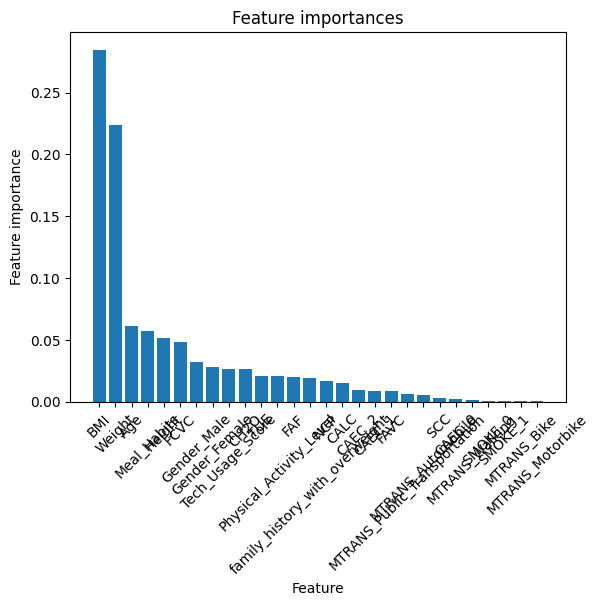

In [30]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)

# Train the classifier
clf.fit(x_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names from x_train columns
feature_names = x_train.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%s): %f" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.show()


In [42]:
# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
})

# Filter features with importance higher than 0.0085
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.0085]['Feature'].tolist()
selected_features


['Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CH2O',
 'FAF',
 'TUE',
 'CALC',
 'Gender_Female',
 'Gender_Male',
 'CAEC_1',
 'CAEC_2',
 'BMI',
 'Physical_Activity_Level',
 'Meal_Habits',
 'Tech_Usage_Score']

In [48]:
x_test_subset

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,FAF,TUE,CALC,Gender_Female,Gender_Male,CAEC_1,CAEC_2,BMI,Physical_Activity_Level,Meal_Habits,Tech_Usage_Score
id,,,,,,,,,,,,,,,,,,,
10317,26.000000,1.649178,111.933010,1,1,3.000000,3.000000,1.292479,0.065264,0.711331,1,1.0,0.0,0.0,1.0,41.155048,0.646067,9.000000,0.027359
4074,18.000000,1.750000,80.000000,0,1,2.000000,3.000000,2.000000,1.000000,1.000000,1,0.0,1.0,0.0,1.0,26.122449,0.000000,6.000000,0.055556
9060,23.360307,1.713380,84.722222,1,1,2.880161,3.000000,2.847264,2.000000,0.002600,0,1.0,0.0,0.0,1.0,28.859576,-1.997400,8.640483,0.000111
11286,30.002029,1.670667,112.000381,1,1,1.572036,3.000000,2.003563,0.000000,0.114457,1,0.0,1.0,0.0,1.0,40.127279,0.114457,4.716108,0.003815
8254,17.000000,1.610000,50.000000,0,1,2.000000,3.000000,2.000000,0.000000,2.000000,0,0.0,1.0,0.0,1.0,19.289379,2.000000,6.000000,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20286,16.000000,1.560000,51.000000,0,1,2.000000,3.000000,2.000000,1.000000,1.000000,1,1.0,0.0,1.0,0.0,20.956607,0.000000,6.000000,0.062500
8233,18.000000,1.780000,108.000000,1,1,2.000000,1.000000,3.000000,1.000000,0.000000,1,0.0,1.0,0.0,1.0,34.086605,-1.000000,2.000000,0.000000
11518,22.693989,1.627908,82.000000,1,1,1.918251,1.000000,1.998108,0.000000,1.382906,1,1.0,0.0,0.0,1.0,30.942410,1.382906,1.918251,0.060937


In [57]:
#apply random forest to previous subset
x_train_subset = x_train.loc[:,selected_features]
x_test_subset = x_test.loc[:,selected_features]

# Initialize and train the Random Forest model with MLflow tracking
rf_model_upd = RandomForestModel()
acc = rf_model_upd.train_and_evaluate(x_train_subset, y_train, x_test_subset, y_test)
print("acc:", acc)

acc: 0.8978805394990366


In [59]:
# Model name and metrics
model_name = 'Random Forest on Subset'


# Create a new row with model name and metrics
new_row = {'Model': model_name}
new_row = {'Model Name': model_name, 'Train Accuracy': round(acc,2)}



# Append new row to DataFrame
metrics_table = metrics_table.append(new_row, ignore_index=True)
metrics_table

,Model Name,Train Accuracy
0,First Neural Network,0.60
1,Second Neural Network,0.57
2,Random Forest,0.90
3,Random Forest on Subset,0.90


In [68]:
selected_features.append('NObeyesdad')

Accuracy is unchanged.

In [70]:
import pycaret
from pycaret.classification import *
df_subset = df.loc[:, selected_features]

obesity_pycaret = setup(data = df_subset, target = 'NObeyesdad')


,Description,Value
0,Session id,6489
1,Target,NObeyesdad
2,Target type,Multiclass
3,Target mapping,"Insufficient_Weight: 0, Normal_Weight: 1, Obesity_Type_I: 2, Obesity_Type_II: 3, Obesity_Type_III: 4, Overweight_Level_I: 5, Overweight_Level_II: 6"
4,Original data shape,"(20758, 20)"
5,Transformed data shape,"(20758, 20)"
6,Transformed train set shape,"(14530, 20)"
7,Transformed test set shape,"(6228, 20)"
8,Numeric features,19
9,Preprocess,True


In [71]:
best_model_subset = compare_models()


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:51:52
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9010,0.9893,0.9010,0.9013,0.9008,0.8839,0.8840,5.1400
gbc,Gradient Boosting Classifier,0.8988,0.9886,0.8988,0.8989,0.8984,0.8813,0.8815,5.3660
rf,Random Forest Classifier,0.8959,0.9874,0.8959,0.8958,0.8955,0.8779,0.8781,0.5420
et,Extra Trees Classifier,0.8841,0.9857,0.8841,0.8836,0.8834,0.8640,0.8642,0.3840
knn,K Neighbors Classifier,0.8698,0.9650,0.8698,0.8697,0.8693,0.8473,0.8474,0.0930
dt,Decision Tree Classifier,0.8380,0.9067,0.8380,0.8386,0.8380,0.8100,0.8101,0.0570
lr,Logistic Regression,0.8368,0.9765,0.8368,0.8343,0.8348,0.8085,0.8088,1.4000
lda,Linear Discriminant Analysis,0.8241,0.9751,0.8241,0.8237,0.8226,0.7937,0.7941,0.0390
nb,Naive Bayes,0.7692,0.9622,0.7692,0.7620,0.7607,0.7288,0.7305,0.0280
svm,SVM - Linear Kernel,0.6454,0.0000,0.6454,0.7224,0.6118,0.5843,0.6096,0.2620


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

: 

# Generating results

In [26]:
test = pd.read_csv('test.csv')

test = prepare_data(test)

test = test.set_index('id')
test.head()


,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,SCC,FAF,...,CAEC_0,CAEC_1,CAEC_2,SMOKE_0,SMOKE_1,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,
20758,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,2.825629,0,0.855400,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20759,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,3.000000,0,1.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20760,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,2.621877,0,0.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20761,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,2.786417,0,0.094851,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20762,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,2.653531,0,0.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [131]:
test.dtypes


Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FAVC                                int64
FCVC                              float64
NCP                               float64
CH2O                              float64
SCC                                 int64
FAF                               float64
TUE                               float64
CALC                                int64
Gender_Female                     float64
Gender_Male                       float64
CAEC_0                            float64
CAEC_1                            float64
CAEC_2                            float64
SMOKE_0                           float64
SMOKE_1                           float64
MTRANS_Automobile                 float64
MTRANS_Bike                       float64
MTRANS_Motorbike                  float64
MTRANS_Public_Transportation      float64
MTRANS_Walking                    

In [124]:
model_uri = ('....c6c83bd2ec/artifacts/random_forest_model') 
model = mlflow.pyfunc.load_model(model_uri)

In [185]:
test['NObeyesdad'] = label_encoder.inverse_transform(model.predict(test))

In [188]:
submission = test[['NObeyesdad']]
submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Normal_Weight
34595,Insufficient_Weight


In [189]:
submission.to_csv('submission_kaggle_rf.csv')

Generating result for GB model

In [27]:
gb_test = test
gb_test['NObeyesdad'] = label_encoder.inverse_transform(best_model.predict(test))
submission_gb = gb_test[['NObeyesdad']]
submission_gb.to_csv('submission_kaggle_gb.csv')

<div id="appendix" style="background-color: #387390; color: white; text-align: center;">
    <h1>Appendix</h2>
</div>
